# Data set clustering and selection [WIP]


## Description:

This notebook contains an example of code to cluster and select limited set of diverse molecules for a single parameter. The overall goal is to be able to filter data sets for training data for an upcoming FF release.

## Prerequisites:
- OpenEye toolkits
- Scikit learn
- qcportal
- numpy
- matplotlib
- openforcefield


## Contributors:

- Hyesu Jang
- David Mobley
- Lee-Ping Wang
- Jessica Maat

## Code Objectives:

1. Obtain data set
2. Determine parameter applied to molecule
3. Bin these molecules based on parameter into a dictionary
4. Compute the chemical graph similarity of all molecules within parameter based bins
5. Select limited set of diverse molecules from the parameter based bins (Question - is exactly 5 molecules a requirement?)
6. Compile results from 4 and 5 for all parameter bins and create final filtered molecules for the training data set
7. Create QC schema from results for QCA data set submission


## Functions:


In [7]:
from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import ForceField
from openeye.oegraphsim import *
from openeye.oechem import *




def load_DS(mol_file):
    """
    Description - 
    Loads in .txt file of smiles and returns a list of all of the smiles
    
    Input - 
    mol_file: A .txt file of smiles for data set analysis
    
    Return - 
    smiles: A list of smiles from mol_file
    
    """
    file = open(mol_file, 'r')
    text = file.readlines()
    smiles = [ line.split()[0] for line in text]
    return smiles




def param_Usage(smilesList, offxml):
    """
    Description - 
    Reads in list of smiles and returns a dictionary of .offxml style parameters as keys 
    and smiles of molecules as items
    
    Input - 
    smilesList: A list of smiles 
    offxml: The .offxml format force field that the parameters will be used with
    
    Return -
    paramDict: A dictionary of .offxml style parameters as keys and smiles of molecules that utilize the 
    parameters of the key
    torsionDict:
    angleDict:
    bondDict:
    """

    # Initialize storage
    torsionDict = dict()
    angle_bondDict = dict()

    # Let's label using our RC force field
    forcefield = ForceField(offxml)

    # Loop over smiles
    for smi in smilesList:

        # Create a simple molecule from SMILES and turn it into a topology.
        molecule = Molecule.from_smiles(smi, allow_undefined_stereo = True)
        topology = Topology.from_molecules([molecule])

        # Run the molecule labeling
        molecule_force_list = forcefield.label_molecules(topology)

    
        # Print out a formatted description of the parameters applied to this molecule
        for mol_idx, mol_forces in enumerate(molecule_force_list):
            for force_tag, force_dict in mol_forces.items():
                for (atom_indices, parameter) in force_dict.items():
                    pid = parameter.id
                    
                    #create two seperate parameter usage dictionaries for (1) angle and bonds and (2) torsions
                    if "a" in pid or "b" in pid:
                        if not pid in angle_bondDict:
                            angle_bondDict[pid] = set()
                        angle_bondDict[pid].add(smi)
                            
                    if "t" in pid: 
                        if not pid in torsionDict:
                            torsionDict[pid] = set()
                        torsionDict[pid].add(smi)
    
    return torsionDict, angle_bondDict


def torsionFilter(paramDict):
    """
    Description - Filtering function specifically to remove molecules that do not have rotable bonds
    
    Input - 
    paramDict: A dictionary of .offxml style parameters as keys and a list of molecules as the items. The keys
    should only consist of .offxml torsion parameters e.g. 't10'
    
    
    Return - 
    torsionDict: A dictionary of .offxml style parameters as keys and molecules that only contain rotatable bonds
    """
    
    #TO DO, Hyesu
    #add filtering rotable bond code
    #
    #
    #
    #
    
    return
    

def selectDiverseMols(paramDict, parameter, eps=0.5, min_samples=5):
    """
    Notes - 
    Only look at torsion terms for parameter input
    Exclude rotatable torsions for torsion drive data sets
    
    
    Description - 
    selectDiverseMols returns a limited set diverse of SMILES for a given parameter in a parameter dictionary.
    The methodology is first computed the graph similarity score and then using DBSCAN to create diverse clusters.
    
    Input - 
    paramDict: A dictionary of .offxml style parameters as keys and smiles of molecules that utilize the 
    parameters of the key
    parameter: An .offxml style parameter of interest e.g. 'a19'
    eps: Controls the maximum distance between two samples considered to be a neighbor of the other. 
    Default is 0.5. This is based of previous experiments and scientific input from David Mobley & Chris Bayly.
    min_samples: Minimum number of samples near a compound for it to be considered a core point. Default = 5.
    
    Return - 
    filtered_Smiles: A list of diverse and limited smiles for a given parameter

    """


    # Select fingerprint type
    # Chris Bayly/Krisztina Boda recommend tree fingerprints with default path length of 4 bonds
    fptype = OEFPType_Tree 

    # Make fingerprints 
    release_set_fp = []
    release_set_mols = []
    
    release_smi = paramDict[parameter]
    
    for smi in release_smi:
        mol = OEMol()
        OEParseSmiles(mol, smi)
        fp = OEFingerPrint()
        OEMakeFP(fp, mol, fptype)
        release_set_fp.append(fp)
        release_set_mols.append(mol)


    import numpy as np
    N = len(release_smi)
    t_matrix = np.zeros( (N,N), np.float)

    comparison_fps = release_set_fp 
    comparison_mols = release_set_mols

    for n in range(N):
        for m in range(N):
            if n != m: #Make diagonal elements be zero for more convenience
                t_matrix[n,m] = OETanimoto( comparison_fps[n], comparison_fps[m])

    #Make distance matrix run from 1 being far to 0 being close rather than the opposite (Tanimoto)
    dis_matrix = np.ones_like(t_matrix)-t_matrix
    print(dis_matrix)
    from sklearn.cluster import DBSCAN
    from sklearn import metrics


    clustering = DBSCAN(eps, min_samples, metric="precomputed")

    # Fit clustering
    db = clustering.fit(dis_matrix)

    # Pull labels
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    
    #Print out 
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Total number of points: %d' % len(dis_matrix))
    print('Estimated number of noise points: %d' % n_noise_)
    
    
    # Determine how many compounds are in each cluster.
    # Cluster "-1" is the "outliers"/noise points that are not in clusters.

    mols_by_cluster = {}
    cluster_nrs = set(labels)

    for label in cluster_nrs:
        mols_by_cluster[label] = []

        for (idx, thislabel) in enumerate(labels):
            if thislabel==label:
                mols_by_cluster[label].append(comparison_mols[idx])

        print("%d molecules in cluster %s" % (len(mols_by_cluster[label]), label))

    filtered_Smiles=[]
    for label, mols in mols_by_cluster.items():
        #sort molecules by size
        sort_mols=sorted(mols, key=lambda x: x.NumAtoms())
        #select smallest molecule
        smallestMolSmiles=OEMolToSmiles(sort_mols[0])

        filtered_Smiles.append(smallestMolSmiles)
    
    return filtered_Smiles




#create two function for optimization and torsion drive datasets 
def create_QCSChema(smilesList):
    """
    Description - 
    Create a .json file for QCA data set submission from a smilesList
    
    Input - 
    List of smiles for QC Schema generation
    """
    
    
    
    return

def main(inputFile):
    #Takes in input file
    return
    
    

## Test for generating data using above function:

In [8]:
#Run an example of functions

smiles=load_DS('test_smiles.txt')
dictofParams=param_Usage(smiles, 'openff_unconstrained-1.0.0-RC1.offxml')
print(dictofParams[0])
print(dictofParams[1])
print(selectDiverseMols(dictofParams[1], 'a1', eps=0.5, min_samples=5))




{'t157': {'C(C#N)N=[N+]=[N-]', 'C#Cc1ccccc1'}, 't44': {'C#Cc1ccccc1'}, 't156': {'C#Cc1ccccc1'}, 't70': {'C(=[NH2+])N'}, 't78': {'C(=[NH2+])N'}, 't69': {'C(=[NH2+])N'}, 't158': {'C(C#N)N=[N+]=[N-]'}, 't65': {'C(C#N)N=[N+]=[N-]'}, 't83': {'C(C#N)N=[N+]=[N-]'}, 't71': {'C(CBr)c1[nH]nnn1'}, 't77': {'C(CBr)c1[nH]nnn1', 'C(CBr)c1n[n-]nn1'}, 't23': {'C(CBr)c1[nH]nnn1'}, 't20': {'C(CBr)c1[nH]nnn1', 'C(CBr)c1n[n-]nn1'}, 't1': {'C(CBr)c1[nH]nnn1', 'C(CBr)c1n[n-]nn1'}, 't12': {'C(CBr)c1[nH]nnn1', 'C(CBr)c1n[n-]nn1'}, 't128': {'C(CBr)c1[nH]nnn1'}, 't129': {'C(CBr)c1[nH]nnn1'}, 't17': {'C(CBr)c1[nH]nnn1', 'C(CBr)c1n[n-]nn1'}, 't130': {'C(CBr)c1[nH]nnn1', 'C(CBr)c1n[n-]nn1'}, 't3': {'C(CBr)c1[nH]nnn1', 'C(CBr)c1n[n-]nn1'}, 't73': {'C(CBr)c1n[n-]nn1'}, 't128a': {'C(CBr)c1n[n-]nn1'}, 't74': {'C(CBr)c1n[n-]nn1'}}
{'b83': {'C(C#N)N=[N+]=[N-]', 'C(CBr)c1n[n-]nn1', 'C', 'C(CBr)c1[nH]nnn1'}, 'a2': {'C(C#N)N=[N+]=[N-]', 'C(CBr)c1n[n-]nn1', 'C', 'C(CBr)c1[nH]nnn1'}, 'b27': {'C#Cc1ccccc1'}, 'b85': {'C#Cc1cccc

## Running through a prelimary example:

## 1. Obtain data set

In [29]:
# Load molecules 
file = open('target_smiles.txt', 'r')
text = file.readlines()
release_smi = [ line.split()[0] for line in text]
print(len(release_smi))
print(release_smi)

645
['C', 'C#Cc1ccccc1', 'C(=[NH2+])N', 'C(C#N)N=[N+]=[N-]', 'C(CBr)c1[nH]nnn1', 'C(CBr)c1n[n-]nn1', 'C(CBr)c1n[nH]nn1', 'C(CO)O', 'C(N)[P@@H](=O)O', 'C(N)[P@H](=O)O', 'C/C=C/C(C)C', 'C/C=C/c1ccccc1C', 'C/C=C/c1ccccc1O', 'C1=N[C@@H](C(=N1)C(=O)N)[N+]#N', 'C1=N[C@H](C(=N1)C(=O)N)[N+]#N', 'C1C(CO1)(CO)O', 'C1CC(=O)N(C1=O)Br', 'C1CC(=O)N(C1=O)I', 'C1CC1(CO)O', 'C1CC1NC(=O)C[N@@H+]2C[C@@H](CO2)O', 'C1CC1NC(=O)C[N@@H+]2C[C@H](CO2)O', 'C1CC1NC(=O)C[N@@]2C[C@@H](CO2)O', 'C1CC1NC(=O)C[N@@]2C[C@H](CO2)O', 'C1CC1NC(=O)C[N@H+]2C[C@@H](CO2)O', 'C1CC1NC(=O)C[N@H+]2C[C@H](CO2)O', 'C1CC1NC(=O)C[N@]2C[C@@H](CO2)O', 'C1CC1NC(=O)C[N@]2C[C@H](CO2)O', 'C1CCC(=O)NCC1', 'C1CS(=O)(=O)CCC12CN=C(O2)N', 'C1CS(=O)(=O)CCC12C[NH+]=C(O2)N', 'C1NC[C@@H]2[C@@H]1[C@H]2O', 'C1NC[C@H]2[C@H]1[C@H]2O', 'C1[C@@H](O1)CCCF', 'C1[C@@H]2[C@@H]([C@@H]2O)CN1', 'C1[C@@H]2[C@@H]([C@@H]2O)C[NH2+]1', 'C1[C@@H]2[C@@H]([C@H]2O)CN1', 'C1[C@@H]2[C@@H]([C@H]2O)C[NH2+]1', 'C1[C@H](O1)CCCF', 'C1[NH2+]C[C@@H]2[C@@H]1[C@H]2O', 'C1[NH2+]C[C@H

## 2. Determine Parameter applied to molecule
## 3. Bin these molecules based on parameter

In [39]:
from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import ForceField

# Initialize storage
parameters_by_ID = dict()

# Let's label using our RC force field
forcefield = ForceField('openff_unconstrained-1.0.0-RC1.offxml')

# Loop over smiles
for smi in release_smi:

    # Create a simple molecule from SMILES and turn it into a topology.
    molecule = Molecule.from_smiles(smi, allow_undefined_stereo = True)
    topology = Topology.from_molecules([molecule])

    # Run the molecule labeling
    molecule_force_list = forcefield.label_molecules(topology)

    #print(smi)
    # Print out a formatted description of the parameters applied to this molecule
    for mol_idx, mol_forces in enumerate(molecule_force_list):
        for force_tag, force_dict in mol_forces.items():
            for (atom_indices, parameter) in force_dict.items():
                pid = parameter.id
                if not pid in parameters_by_ID:
                    parameters_by_ID[pid] = set()
                parameters_by_ID[pid].add(smi)

print(parameters_by_ID)

{'b83': {'Cc1cccc(c1C(=O)C)C', 'CNc1ccccc1c2ccccn2', 'CNC(=O)Nc1ccccn1', 'CN(c1ccccc1)c2ccccn2', 'C1=N[C@@H](C(=N1)C(=O)N)[N+]#N', 'C[C@@]1(CC(=O)N1)c2[nH+]ccs2', 'CN(C)c1ccccc1', 'CC(=O)NC', 'Cc1cc[nH]c(=O)c1C(=O)NC', 'c1ccc(cc1)C2CC2', 'CCCN1CCCC1=O', 'CC1([C@H]2[C@H]1CCC2)O', 'CN(C)C(=O)c1c(cc[nH]1)N', 'C[C@H](c1ccccc1)N2CC[NH2+]CC2', 'Cc1ccnn1c2c(cccn2)F', 'c1ccnc(c1)C2CC[NH2+]CC2', 'C=C/C=[N+]/1\\CCC=C1O', 'CC(=O)N[P@](=O)(OC)SC', 'Cn1cccc1C(=S)N=P(N(C)C)(N(C)C)N(C)C', 'c1ccc(cc1)C2C=CNC=C2', 'c1ccc(cc1)CCF', 'CC(=O)Oc1cccc(=O)n1C', 'CNCC(Cl)Cl', 'Cc1cccc(c1OC)C', 'CN(C)S(=O)(=O)c1ccccc1', 'c1ccnc(c1)Cc2cccc(=O)[nH]2', 'CCn1ccccc1=O', 'CS', 'c1cc([nH]c(=O)c1)[C@@H]2CCCO2', 'CN(C)S(=O)(=O)c1ccccn1', 'CC(=O)NC1(CC1)c2[nH]ccn2', 'CC(=O)Nc1ccccn1', 'CCCC', 'CC(=O)OC1CC1', 'CCc1ccccc1', 'Cc1cccc2c1C(=O)NCCC2', 'C[C@H](c1ccccc1)S(=O)(=O)C', 'CN1c2ccccc2CCCC1=O', 'CC[C@H](CCl)Cl', 'CNC(=O)[S-]', 'C1CS(=O)(=O)CCC12C[NH+]=C(O2)N', 'c1ccc(cc1)N2CCCCC2=O', 'C1CC1NC(=O)C[N@H+]2C[C@H](CO2)O', 

## 4. Compute the chemical graph similarity of all molecules in a parameter bin

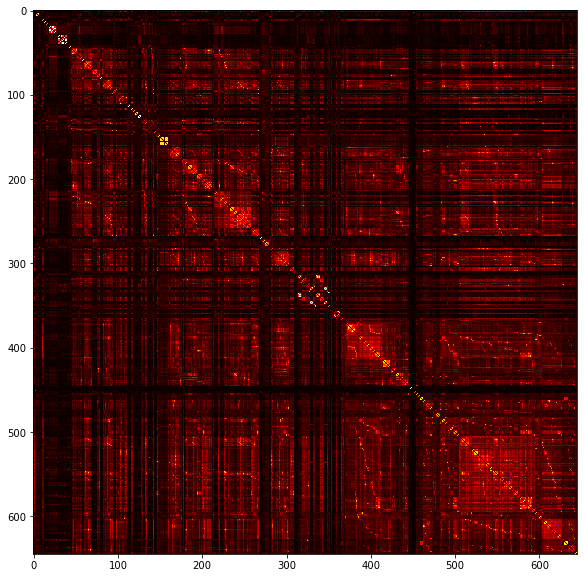

In [30]:
from openeye.oegraphsim import *
from openeye.oechem import *

# Select fingerprint type
# Chris Bayly/Krisztina Boda recommend tree fingerprints with default path length of 4 bonds
fptype = OEFPType_Tree 

# Make fingerprints 
release_set_fp = []
release_set_mols = []
for smi in release_smi:
    mol = OEMol()
    OEParseSmiles(mol, smi)
    fp = OEFingerPrint()
    OEMakeFP(fp, mol, fptype)
    release_set_fp.append(fp)
    release_set_mols.append(mol)
    


import numpy as np
N = len(release_smi)
t_matrix = np.zeros( (N,N), np.float)

comparison_fps = release_set_fp 
comparison_mols = release_set_mols

for n in range(N):
    for m in range(N):
        if n != m: #Make diagonal elements be zero for more convenience
            t_matrix[n,m] = OETanimoto( comparison_fps[n], comparison_fps[m])

import matplotlib.pyplot as plt
%matplotlib inline

# Plot part of matrix
plt.figure(figsize =(10,10))
plt.imshow(t_matrix, cmap='hot')



## 5. Select 5 most diverse molecules from the parameter based bins

In [36]:
#Make distance matrix run from 1 being far to 0 being close rather than the opposite (Tanimoto)
dis_matrix = np.ones_like(t_matrix)-t_matrix
print(dis_matrix)
from sklearn.cluster import DBSCAN
from sklearn import metrics

# eps: Controls maximum distance between two samples to be considered as in neighborhood of the other.
# min_samples: Minimum number of samples (compounds) near a compound for it to be considered a core point
# Metric: precomputed means use precomputed distance matrix

clustering = DBSCAN(eps=0.5, min_samples = 7, metric="precomputed")

# Fit clustering
db = clustering.fit(dis_matrix)

# Pull labels
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Total number of points: %d' % len(dis_matrix))
print('Estimated number of noise points: %d' % n_noise_)

[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 0.94666667 0.93939394 0.95049505]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [1.         0.94666667 1.         ... 1.         0.94308943 0.952     ]
 [1.         0.93939394 1.         ... 0.94308943 1.         0.27472527]
 [1.         0.95049505 1.         ... 0.952      0.27472527 1.        ]]
Estimated number of clusters: 6
Total number of points: 645
Estimated number of noise points: 552


In [37]:
# Determine how many compounds are in each cluster.
# Cluster "-1" is the "outliers"/noise points that are not in clusters.

mols_by_cluster = {}
cluster_nrs = set(labels)

for label in cluster_nrs:
    mols_by_cluster[label] = []
    
    for (idx, thislabel) in enumerate(labels):
        if thislabel==label:
            mols_by_cluster[label].append(comparison_mols[idx])
            
    print("%d molecules in cluster %s" % (len(mols_by_cluster[label]), label))

35 molecules in cluster 0
8 molecules in cluster 1
8 molecules in cluster 2
26 molecules in cluster 3
8 molecules in cluster 4
8 molecules in cluster 5
552 molecules in cluster -1


In [38]:
# Generate PDF files visualizing the contents of all clusters except -1

from openeye import oedepict
import shutil
import os
if os.path.isdir('cluster_pdfs'): shutil.rmtree('cluster_pdfs')
os.mkdir('cluster_pdfs')

for label in mols_by_cluster:
    if label=='-1':
        continue
        
    oemols = [ OEMol(mol) for mol in mols_by_cluster[label]]
    itf = oechem.OEInterface()
    PageByPage = True
    suppress_h = True
    rows = 10
    cols = 6
    ropts = oedepict.OEReportOptions(rows, cols)
    ropts.SetHeaderHeight(25)
    ropts.SetFooterHeight(25)
    ropts.SetCellGap(2)
    ropts.SetPageMargins(10)
    report = oedepict.OEReport(ropts)
    cellwidth, cellheight = report.GetCellWidth(), report.GetCellHeight()
    opts = oedepict.OE2DMolDisplayOptions(cellwidth, cellheight, oedepict.OEScale_Default * 0.5)
    opts.SetAromaticStyle(oedepict.OEAromaticStyle_Circle)
    pen = oedepict.OEPen(oechem.OEBlack, oechem.OEBlack, oedepict.OEFill_On, 1.0)
    opts.SetDefaultBondPen(pen)
    oedepict.OESetup2DMolDisplayOptions(opts, itf)
    for i, mol in enumerate(oemols):
        cell = report.NewCell()
        mol_copy = oechem.OEMol(mol)
        oedepict.OEPrepareDepiction(mol_copy, False, suppress_h)
        disp = oedepict.OE2DMolDisplay(mol_copy, opts)

        oedepict.OERenderMolecule(cell, disp)

    oedepict.OEWriteReport("cluster_test_pdf/cluster%s.pdf" % label, report)

In [ ]:
#Run an example of functions

smiles=load_DS('target_smiles.txt')
print(smiles)
dictofParams=param_Usage(smiles, 'openff_unconstrained-1.0.0-RC1.offxml')
print(dictofParams)
print(selectDiverseMols(dictofParams, 'a3', eps=0.5, min_samples=5))